# Model Tire Degredation

Load data

In [1]:
import fastf1
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from fastf1 import plotting
from matplotlib import pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

plotting.setup_mpl()

race = fastf1.get_session(2022, "Hungarian Grand Prix", "R")
race.load()
laps_df = race.laps.copy()

api         WARNING 	

NO CACHE! Api caching has not been enabled! 
	It is highly recommended to enable this feature for much faster data loading!
	Use `fastf1.Cache.enable_cache('path/to/cache/')`

core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Fetching driver list...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Fetching timing app data...
core           INFO 	Processing timing data...
api            INFO 	Fetching session status data...
api            INFO 	Fetching track status data...
/opt/homebrew/lib/python3.9/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
/opt/homebrew/lib/python3.9/site-packages/fastf1/core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteri

Configure parameters

In [59]:
fuel_mass_start_kg = 110
fuel_mass_end_kg = 0
lap_time_loss_per_fuel_mass_kilo_per_sec = 0.03
n_laps = 70

Prepare lap times dataframe for all stints to compute LOWESS models for each tire compound.

1. First we remove the first lap and last lap because it is not representative as each car travel different distance from their grid position to complete the lap.
2. We consider each car is filled with 110 kilos of fuel at the start and finishes with 0 kilos at the end. For each kilo of fuel we assume a lap time loss of 0.03s.
3. To remove outliers such as safety car, virtual safety car, spins, driver errors we only consider laps with lap time within 107% of the fastest lap of the race.
4. To arrive at the lap times for each compound, we use LOWESS (Locally Weighted Scatterplot Smoothing) which gives us a nice model fit for scattered data points.
5. We use Tyre Life as x-axis instead of Lap Number to use all the data available across various stints. And for y-axis we use the Fuel corrected lap times.

There are still several factors that effect tyre performance but are difficult to account for such as driver errors, car performance, wind, traffic, DRS and so on, but still this is a decent approximation used by formula1 engineers because it works.

Source: https://tracinginsights.substack.com/p/ferrari-disaster-class-is-hard-compound

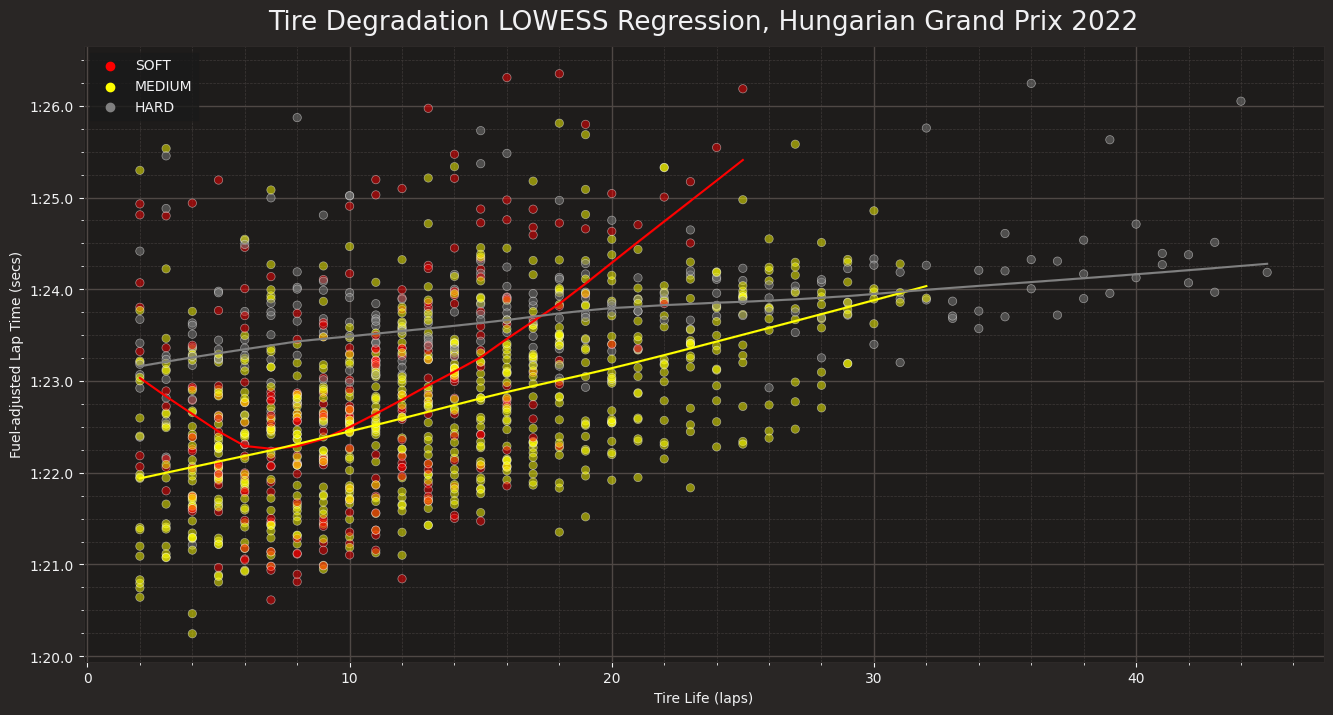

In [65]:
# calculate lap-wise lap time loss by fuel loss
lap_time_fuel_loss =  pd.to_timedelta(np.linspace(fuel_mass_start_kg, fuel_mass_end_kg, n_laps) * lap_time_loss_per_fuel_mass_kilo_per_sec, unit="sec")

# find fastest lap and calculate outliers threshold
fastest_lap = laps_df["LapTime"].min()
threshold = fastest_lap * 1.07

# adjust lap times for each stint
stints = []
driver_stints = laps_df.groupby(["DriverNumber", "Stint"]) # , "TyreLife", "LapTime"])
for (driver_no, stint_no), stint_df in driver_stints:
    if len(stint_df) == 0:
        continue
    start_lap, end_lap = stint_df["LapNumber"].min(), stint_df["LapNumber"].max()
    if np.isnan(start_lap) or np.isnan(end_lap):
        continue
    stint_df = stint_df[["LapNumber", "TyreLife", "Compound", "LapTime"]]
    # 1. remove first lap and last lap because car didn't travel same distance from pits or starting grid position
    stint_df = stint_df[1:-1]
    # 2. adjust for fuel mass
    stint_df["FuelAdjLapTime"] = stint_df["LapTime"] - lap_time_fuel_loss[start_lap + 1:end_lap]
    # 3. remove outliers
    stint_df = stint_df[stint_df["LapTime"] <= threshold]
    stints.append(stint_df)

# create time adjusted lap frame
laps_adj_df = pd.concat(stints, ignore_index=True)
laps_adj_df["TyreLife"] = laps_adj_df["TyreLife"].astype(int)

# create frames for each tire compound
hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"]
medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"]
soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"]

# apply lowess regression
x_hard, y_hard = lowess(
    endog=hard_df["FuelAdjLapTime"].dt.total_seconds(), exog=hard_df["TyreLife"], 
    frac=0.5, it=5, return_sorted = True).T

x_medium, y_medium = lowess(
    endog=medium_df["FuelAdjLapTime"].dt.total_seconds(), exog=medium_df["TyreLife"], 
    frac=0.5, it=5, return_sorted = True).T

x_soft, y_soft = lowess(
    endog=soft_df["FuelAdjLapTime"].dt.total_seconds(), exog=soft_df["TyreLife"], 
    frac=0.5, it=5, return_sorted = True).T

# plot
palette = {
    "HARD": "gray",
    "MEDIUM": "yellow",
    "SOFT": "red",
}

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title("Tire Degradation LOWESS Regression, Hungarian Grand Prix 2022")
ax.set_ylabel("Fuel-adjusted Lap Time (secs)")
ax.set_xlabel("Tire Life (laps)")
sns.scatterplot(data=laps_adj_df, x="TyreLife", y="FuelAdjLapTime", hue="Compound", palette=palette, alpha=0.50)
sns.lineplot(x=x_soft.astype(int), y=pd.to_timedelta(y_soft, unit="S"), ax=ax, color="red")
sns.lineplot(x=x_medium.astype(int), y=pd.to_timedelta(y_medium, unit="S"), ax=ax, color="yellow")
sns.lineplot(x=x_hard.astype(int), y=pd.to_timedelta(y_hard, unit="S"), ax=ax, color="gray")
ax.invert_yaxis()


## What did Ferrari know by Lap 39?


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2651165075.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= decision_lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2651165075.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= decision_lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2651165075.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= decision_lap]


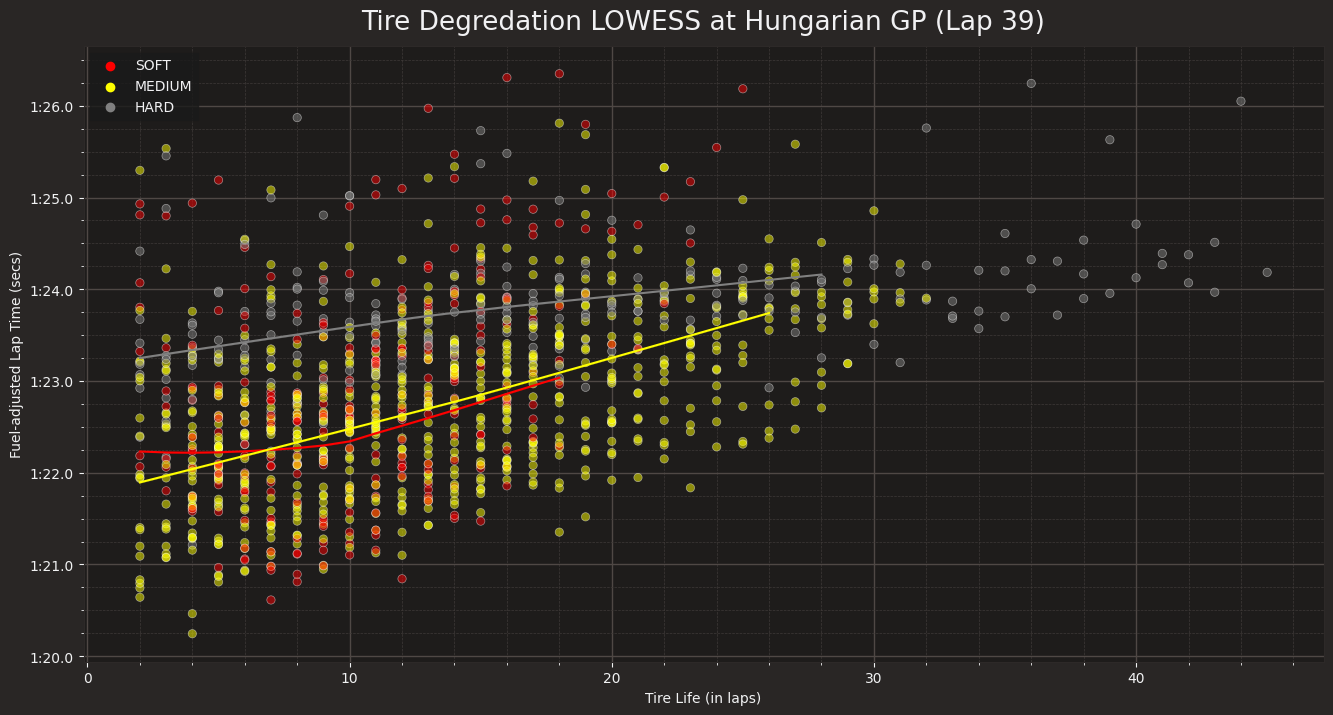

In [61]:
decision_lap = 39
lowess_frac = 1

# create frames for each tire compound
hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= decision_lap] 
medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= decision_lap] 
soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= decision_lap] 

# apply lowess regression
x_hard, y_hard = lowess(
    endog=hard_df["FuelAdjLapTime"].dt.total_seconds(), exog=hard_df["TyreLife"], 
    frac=lowess_frac, it=5, return_sorted=True).T

x_medium, y_medium = lowess(
    endog=medium_df["FuelAdjLapTime"].dt.total_seconds(), exog=medium_df["TyreLife"], 
    frac=lowess_frac, it=5, return_sorted=True).T

x_soft, y_soft = lowess(
    endog=soft_df["FuelAdjLapTime"].dt.total_seconds(), exog=soft_df["TyreLife"], 
    frac=lowess_frac, it=5, return_sorted=True).T

# plot
palette = {
    "HARD": "gray",
    "MEDIUM": "yellow",
    "SOFT": "red",
}

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title("Tire Degredation LOWESS at Hungarian GP (Lap 39)")
ax.set_ylabel("Fuel-adjusted Lap Time (secs)")
ax.set_xlabel("Tire Life (in laps)")
sns.scatterplot(data=laps_adj_df, x="TyreLife", y="FuelAdjLapTime", hue="Compound", palette=palette, alpha=0.50)
sns.lineplot(x=x_soft.astype(int), y=pd.to_timedelta(y_soft, unit="S"), ax=ax, color="red")
sns.lineplot(x=x_medium.astype(int), y=pd.to_timedelta(y_medium, unit="S"), ax=ax, color="yellow")
sns.lineplot(x=x_hard.astype(int), y=pd.to_timedelta(y_hard, unit="S"), ax=ax, color="gray")
ax.invert_yaxis()


### Regression model to find $k_0$, $k_1$ tire parameters

In [34]:
lap = 39

# create frames for each tire compound
hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= lap] 
medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= lap] 
soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= lap] 

# hard compound tire model
m_hard = sm.OLS(
    endog=(hard_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(hard_df[["TyreLife"]], prepend=False))
r_hard = m_hard.fit()
print("Hard:", r_hard.params.to_dict())

# medium compound tire
m_medium = sm.OLS(
    endog=(medium_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(medium_df[["TyreLife"]], prepend=False))
r_medium = m_medium.fit()
print("Medium:", r_medium.params.to_dict())

# soft compound tire
m_soft = sm.OLS(
    endog=(soft_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(soft_df[["TyreLife"]], prepend=False))
r_soft = m_soft.fit()
print("Soft:", r_soft.params.to_dict())

Hard: {'TyreLife': 0.03507985799937343, 'const': 1.8991196824904748}
Medium: {'TyreLife': 0.07524075278919753, 'const': 0.3591860302997177}
Soft: {'TyreLife': 0.04042509545426383, 'const': 0.6293418072676631}


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2000750994.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2000750994.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2000750994.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= lap]


In [24]:
r_hard.params.to_dict()

{'TyreLife': 0.03507985799937343, 'const': 1.8991196824904748}

### Plotting tire degredation regression models

Text(0.5, 0, 'Tire Life (in laps)')

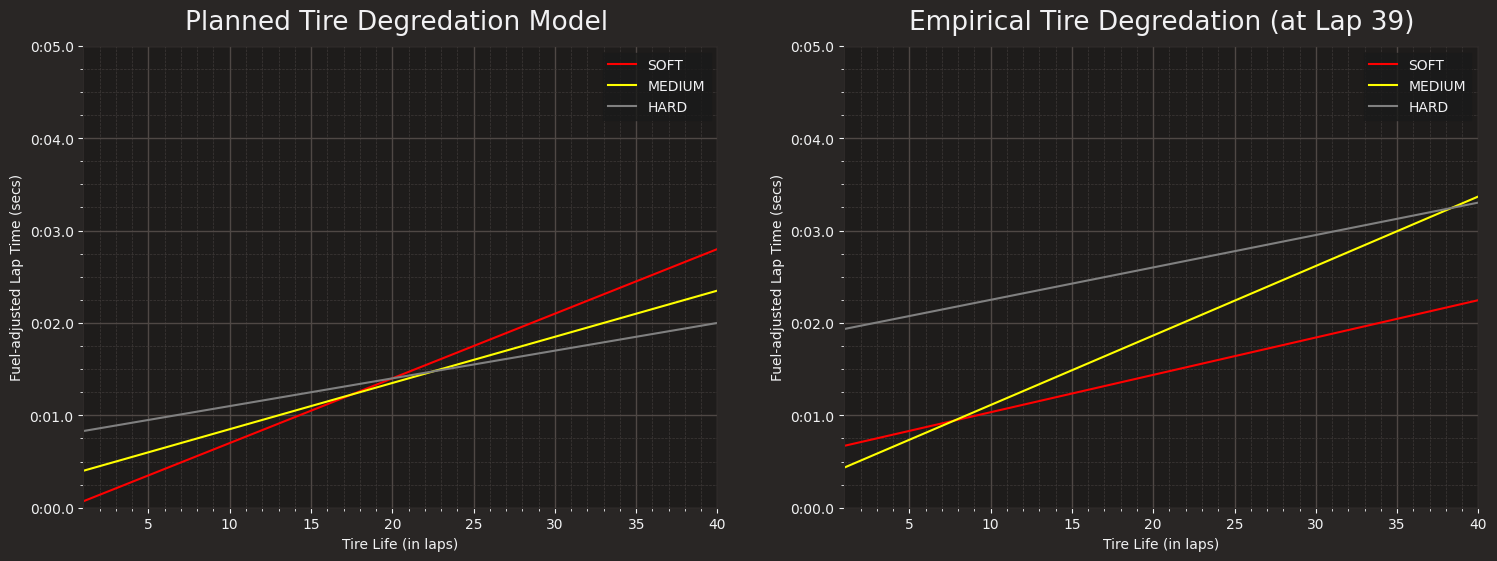

In [50]:
k_0_hard = r_hard.params.to_dict()["const"]
k_1_hard = r_hard.params.to_dict()["TyreLife"]

k_0_medium = r_medium.params.to_dict()["const"]
k_1_medium = r_medium.params.to_dict()["TyreLife"] 

k_0_soft = r_soft.params.to_dict()["const"]
k_1_soft = r_soft.params.to_dict()["TyreLife"]

laps = np.arange(0, 70)
l_hard_obs = k_0_hard + k_1_hard * laps
l_medium_obs = k_0_medium + k_1_medium * laps
l_soft_obs = k_0_soft + k_1_soft * laps

# orig model 
l_hard_plan = 0.8 + 0.03 * laps
l_medium_plan = 0.35 + 0.05 * laps
l_soft_plan = 0.0 + 0.07 * laps

# plot
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(x=laps, y=pd.to_timedelta(l_soft_plan, unit="S"), color="red", ax=ax[0], label="SOFT")
sns.lineplot(x=laps, y=pd.to_timedelta(l_medium_plan, unit="S"), color="yellow", ax=ax[0], label="MEDIUM")
sns.lineplot(x=laps, y=pd.to_timedelta(l_hard_plan, unit="S"), color="gray", ax=ax[0], label="HARD")
ax[0].set_xlim([1, 40])
ax[0].set_ylim([pd.to_timedelta(5, unit="S"), pd.to_timedelta(0, unit="S")])
ax[0].invert_yaxis()
ax[0].set_title("Planned Tire Degredation Model ")
ax[0].set_ylabel("Fuel-adjusted Lap Time (secs)")
ax[0].set_xlabel("Tire Life (in laps)")

sns.lineplot(x=laps, y=pd.to_timedelta(l_soft_obs, unit="S"), color="red", ax=ax[1], label="SOFT")
sns.lineplot(x=laps, y=pd.to_timedelta(l_medium_obs, unit="S"), color="yellow", ax=ax[1], label="MEDIUM")
sns.lineplot(x=laps, y=pd.to_timedelta(l_hard_obs, unit="S"), color="gray", ax=ax[1], label="HARD")
ax[1].set_xlim([1, 40])
ax[1].set_ylim([pd.to_timedelta(5, unit="S"), pd.to_timedelta(0, unit="S")])
ax[1].invert_yaxis()
ax[1].set_title("Empirical Tire Degredation (at Lap 39)")
ax[1].set_ylabel("Fuel-adjusted Lap Time (secs)")
ax[1].set_xlabel("Tire Life (in laps)")

Here is a plot showing the regression of tire lap on time penalty for hard (gray), medium (yellow), soft (red) from the original model; and regression for time penalty observed during the race up to lap 3.

* Hard tire performed much worse than expected (time penalty is much higher across the board.
* Medium tire performed a lot better than hard tire than expected. the “cross-over” point where hard performs better than medium originally was lap 21, and that’s around when Leclerc pitted at lap 20 and 39. Indeed, Leclerc told the pit wall his tires were fine. The observed data suggests the cross-over point is actually at lap 39. Indeed, Verstappen won the race with a one-stop - he rode a medium tire for 39 lap; Russel used the same strategy as Verstappen, ending third, ahead of Leclerc at 6.
* Llinear model doesn’t seem appropriate for soft tire.

Also complicating: Leclerc didn't have fresh tires. If he followed Hamilton's strategy, his remaining soft tires wouldn't have made it to the end.

### Plot quadratic regression model

Hard: {'TyreLife': 0.06443662189314218, 'TyreLife2': -0.0011246521745573105, 'const': 1.7569913131774038}
Medium: {'TyreLife': 0.06202316977486645, 'TyreLife2': 0.0005240676083454657, 'const': 0.4235052139530544}
Soft: {'TyreLife': -0.2616598962491782, 'TyreLife2': 0.015162643477906683, 'const': 1.925351382015153}


/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2903178575.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2903178575.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2903178575.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= lap]
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_50624/2903178575.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Text(0.5, 0, 'Tire Life (in laps)')

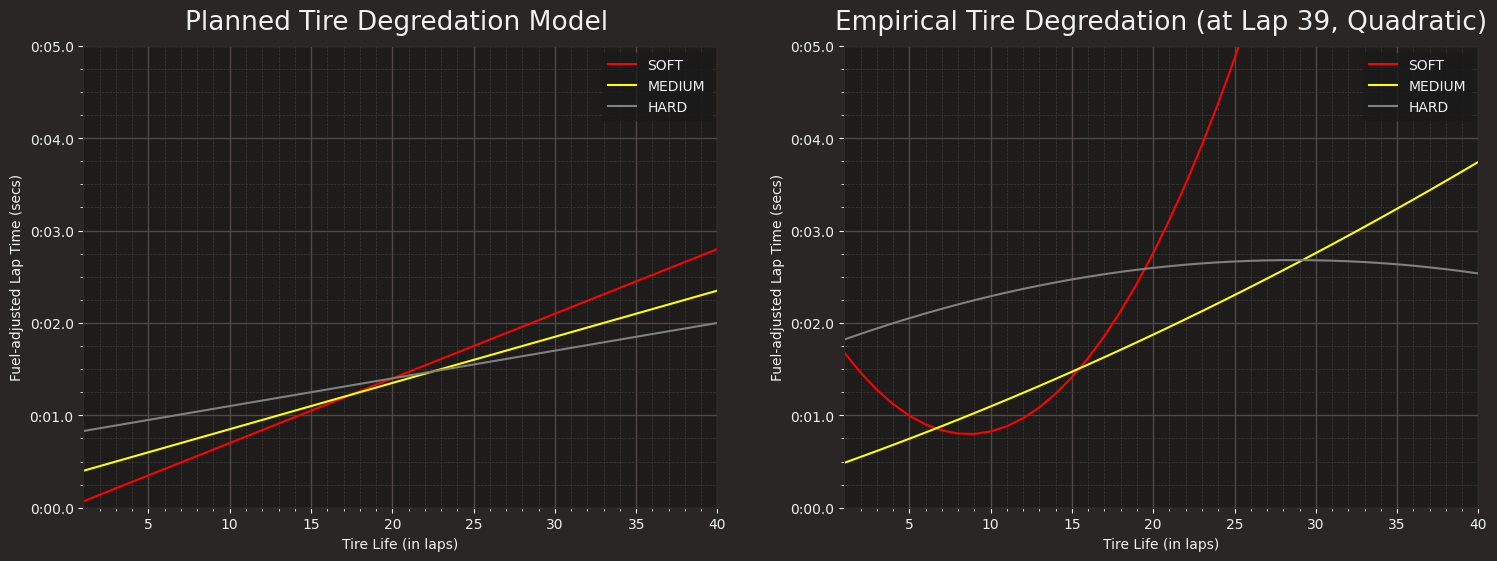

In [78]:
lap = 39

# create frames for each tire compound
hard_df = laps_adj_df[laps_adj_df["Compound"] == "HARD"][laps_adj_df["LapNumber"] <= lap] 
medium_df = laps_adj_df[laps_adj_df["Compound"] == "MEDIUM"][laps_adj_df["LapNumber"] <= lap] 
soft_df = laps_adj_df[laps_adj_df["Compound"] == "SOFT"][laps_adj_df["LapNumber"] <= lap]

hard_df["TyreLife2"] = hard_df["TyreLife"].pow(2)
medium_df["TyreLife2"] = medium_df["TyreLife"].pow(2)
soft_df["TyreLife2"] = soft_df["TyreLife"].pow(2)

# hard compound tire model
m_hard = sm.OLS(
    endog=(hard_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(hard_df[["TyreLife", "TyreLife2"]], prepend=False))
r_hard = m_hard.fit()
print("Hard:", r_hard.params.to_dict())

# medium compound tire
m_medium = sm.OLS(
    endog=(medium_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(medium_df[["TyreLife", "TyreLife2"]], prepend=False))
r_medium = m_medium.fit()
print("Medium:", r_medium.params.to_dict())

# soft compound tire
m_soft = sm.OLS(
    endog=(soft_df["FuelAdjLapTime"] - fastest_lap).dt.total_seconds(),
    exog=sm.add_constant(soft_df[["TyreLife", "TyreLife2"]], prepend=False))
r_soft = m_soft.fit()
print("Soft:", r_soft.params.to_dict())

# extract constants
k_0_hard = r_hard.params.to_dict()["const"]
k_1_hard = r_hard.params.to_dict()["TyreLife"]
k_2_hard = r_hard.params.to_dict()["TyreLife2"]

k_0_medium = r_medium.params.to_dict()["const"]
k_1_medium = r_medium.params.to_dict()["TyreLife"] 
k_2_medium = r_medium.params.to_dict()["TyreLife2"]

k_0_soft = r_soft.params.to_dict()["const"]
k_1_soft = r_soft.params.to_dict()["TyreLife"]
k_2_soft = r_soft.params.to_dict()["TyreLife2"]

laps = np.arange(0, 70)
l_hard_obs = k_0_hard + k_1_hard * laps + k_2_hard * laps ** 2
l_medium_obs = k_0_medium + k_1_medium * laps + k_2_medium * laps ** 2
l_soft_obs = k_0_soft + k_1_soft * laps + k_2_soft * laps ** 2

# orig model 
l_hard_plan = 0.8 + 0.03 * laps
l_medium_plan = 0.35 + 0.05 * laps
l_soft_plan = 0.0 + 0.07 * laps

# plot
fig, ax = plt.subplots(1, 2, figsize=(18, 6))``
sns.lineplot(x=laps, y=pd.to_timedelta(l_soft_plan, unit="S"), color="red", ax=ax[0], label="SOFT")
sns.lineplot(x=laps, y=pd.to_timedelta(l_medium_plan, unit="S"), color="yellow", ax=ax[0], label="MEDIUM")
sns.lineplot(x=laps, y=pd.to_timedelta(l_hard_plan, unit="S"), color="gray", ax=ax[0], label="HARD")
ax[0].set_xlim([1, 40])
ax[0].set_ylim([pd.to_timedelta(5, unit="S"), pd.to_timedelta(0, unit="S")])
ax[0].invert_yaxis()
ax[0].set_title("Planned Tire Degredation Model ")
ax[0].set_ylabel("Fuel-adjusted Lap Time (secs)")
ax[0].set_xlabel("Tire Life (in laps)")

sns.lineplot(x=laps, y=pd.to_timedelta(l_soft_obs, unit="S"), color="red", ax=ax[1], label="SOFT")
sns.lineplot(x=laps, y=pd.to_timedelta(l_medium_obs, unit="S"), color="yellow", ax=ax[1], label="MEDIUM")
sns.lineplot(x=laps, y=pd.to_timedelta(l_hard_obs, unit="S"), color="gray", ax=ax[1], label="HARD")
ax[1].set_xlim([1, 40])
ax[1].set_ylim([pd.to_timedelta(5, unit="S"), pd.to_timedelta(0, unit="S")])
ax[1].invert_yaxis()
ax[1].set_title("Empirical Tire Degredation (at Lap 39, Quadratic)")
ax[1].set_ylabel("Fuel-adjusted Lap Time (secs)")
ax[1].set_xlabel("Tire Life (in laps)")

## Step-by-step guide

### Plot Lap Times over Laps

Text(0, 0.5, 'Lap Time')

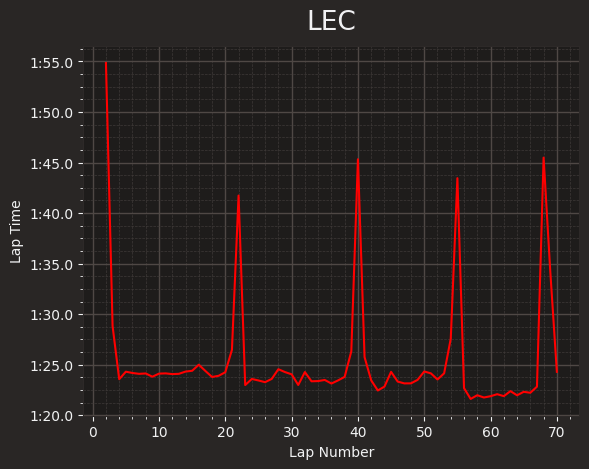

In [85]:
lec = race.laps.pick_driver("LEC")

fig, ax = plt.subplots()
ax.plot(lec["LapNumber"], lec["LapTime"], color="red")
ax.set_title("LEC")
ax.set_xlabel("Lap Number")
ax.set_ylabel("Lap Time")

### Plot Lap Time for Hard Stint

Text(0, 0.5, 'Lap Time')

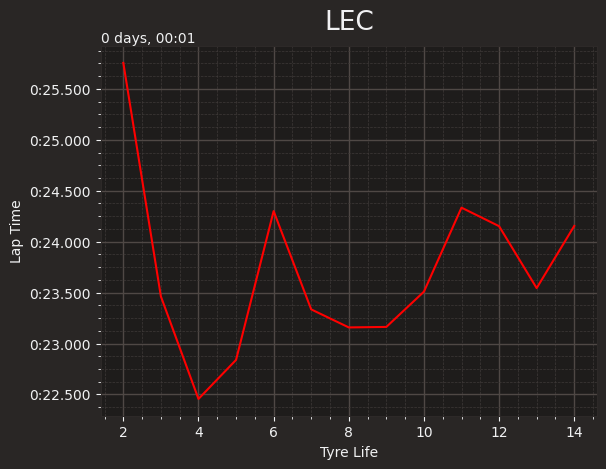

In [86]:
hard_stint = lec[lec["Compound"] == "HARD"][["LapNumber", "TyreLife", "LapTime"]][1:-1]
fig, ax = plt.subplots()
ax.plot(hard_stint["TyreLife"], hard_stint["LapTime"], color="red")
ax.set_title("LEC")
ax.set_xlabel("Tyre Life")
ax.set_ylabel("Lap Time")

### Plot Lap Time Adjusted for Fuel Load for Hard Stint

Text(0, 0.5, 'Fuel Adjusted Lap Time')

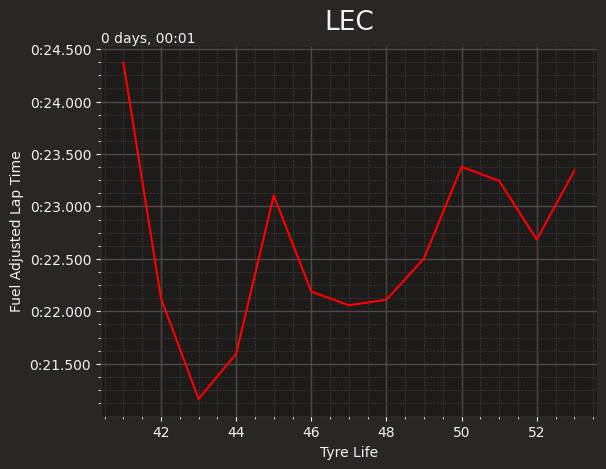

In [87]:
import numpy as np
import pandas as pd

# lap time loss sec = 110 kg * 0.03 sec / kg
fuel_mass_start_kg = 110
fuel_mass_end_kg = 0
lap_time_loss_per_fuel_mass_kilo_per_sec = 0.03
n_laps = lec.shape[0]

lap_time_adjusted = lec["LapTime"] - pd.to_timedelta(np.linspace(fuel_mass_start_kg, fuel_mass_end_kg, n_laps) * lap_time_loss_per_fuel_mass_kilo_per_sec, unit="sec")
lec = lec.assign(LapTimeAdjFuel=lap_time_adjusted)
stint = lec[lec["Compound"] == "HARD"][["LapNumber", "TyreLife", "LapTimeAdjFuel"]][1:-1]

fig, ax = plt.subplots()
ax.plot(stint["LapNumber"], stint["LapTimeAdjFuel"], color="red")
ax.set_title("LEC")
ax.set_xlabel("Tyre Life")
ax.set_ylabel("Fuel Adjusted Lap Time")

### Remove outliers

/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_81964/3476703669.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stint = lec[lec["Compound"] == "HARD"][lec["LapTime"] <= threshold][["LapNumber", "TyreLife", "LapTimeAdjFuel"]][1:-1]


Text(0, 0.5, 'Fuel Adjusted Lap Time')

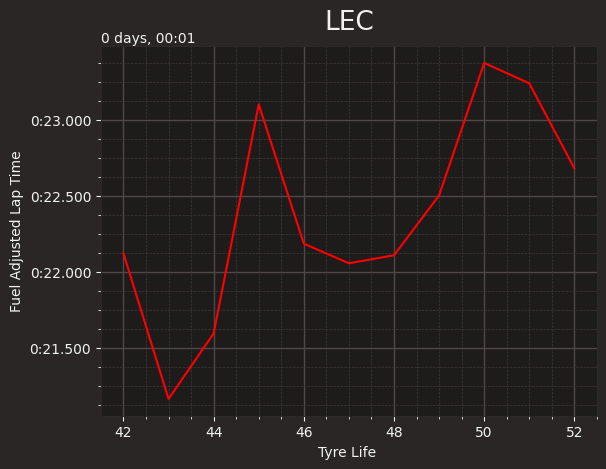

In [88]:
fastest_lap = lec["LapTime"].min()
threshold = fastest_lap * 1.07

stint = lec[lec["Compound"] == "HARD"][lec["LapTime"] <= threshold][["LapNumber", "TyreLife", "LapTimeAdjFuel"]][1:-1]

fig, ax = plt.subplots()
ax.plot(stint["LapNumber"], stint["LapTimeAdjFuel"], color="red")
ax.set_title("LEC")
ax.set_xlabel("Tyre Life ")
ax.set_ylabel("Fuel Adjusted Lap Time")